# Import modules as needed

In [1]:
import fredapi
from fredapi import Fred
import pandas as pd
import numpy as np
from warnings import simplefilter
simplefilter('ignore')
from datetime import datetime, date
from tqdm import tqdm
import timeit
import matplotlib.pyplot as plt
import gc

In [2]:
api_key='8aca3e5caf000a8104c82ff00ec9833f'
fred=Fred(api_key=api_key)

# Data Collection: 
### Use the FRED API to collect the historical data for the S&P/Case-Shiller U.S. National Home Price Index.

In [3]:
# Fetch the S&P/Case-Shiller U.S. National Home Price Index data, seasonly adjusted
home_price_index = fred.get_series_all_releases('CSUSHPISA')
home_price_index = home_price_index.rename(columns={'value':'Case-Shiller Index'})
home_price_index.tail()

,realtime_start,date,Case-Shiller Index
16754,2023-10-31,2023-07-01,306.634
16755,2023-11-28,2023-07-01,306.767
16756,2023-10-31,2023-08-01,309.404
16757,2023-11-28,2023-08-01,309.155
16758,2023-11-28,2023-09-01,311.175


It is seen from the S&P/Case-Shiller index dataset that the data is usually released at month end with two month delay, e.g. Sept data will be available around end of Nov. In addition, the data is constantly revised.

In [4]:
# Special Treatment: Case-Shiller index is available on FRED API after 2014/11/25
# This creates loss of data because no training data of Case-Shiller index will be available before 2014/11/25
# For this reason we convert dates before 2014/11/25 to (T+3M) of report date.
home_price_index.loc[home_price_index['realtime_start']<=pd.Timestamp(2014,11,25), 'realtime_start'] = home_price_index['date'] + pd.Timedelta(days=93)

We plot the S&P/Case-Shiller index to visualize its trend and roughly check the stationarity of its return series.

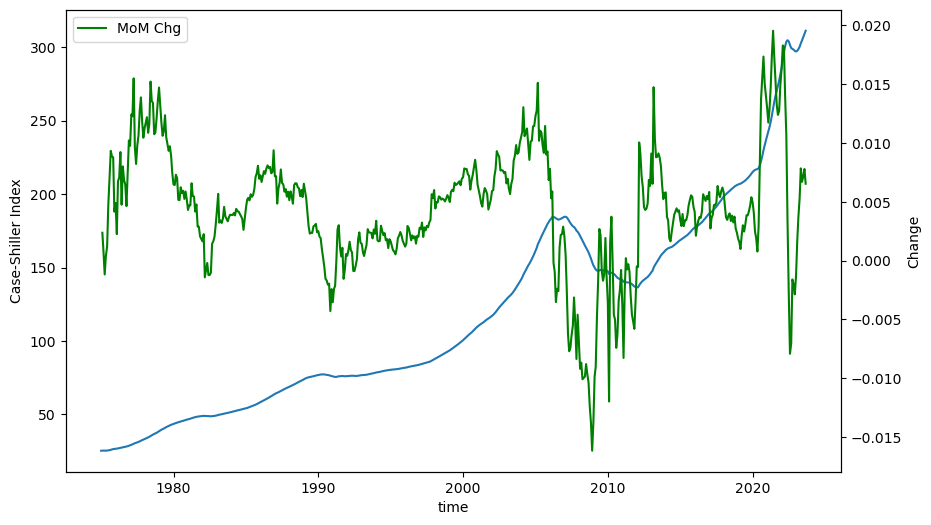

In [5]:
# realtime_start marks the first date when the data is available
# plot home price index change
home_price_index = home_price_index.sort_values(['date','realtime_start'])
home_price_index_first = home_price_index.groupby('date').first()
home_price_index_first.index = home_price_index_first.index.to_period('M')
home_price_index_latest = home_price_index.groupby('date').last()
home_price_index_latest.index = home_price_index_latest.index.to_period('M')

# visualize series change on the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'blue'
ax1.set_xlabel('time')
ax1.set_ylabel('Case-Shiller Index')
ax1.plot(home_price_index_latest.index.to_timestamp(), home_price_index_latest['Case-Shiller Index'])
ax1.tick_params(axis='y')

# Instantiate a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Change') 

ax2.plot(home_price_index_latest.index.to_timestamp(), home_price_index_latest['Case-Shiller Index'].pct_change(), color='green', label='MoM Chg')
#ax2.plot(home_price_index_latest.index.to_timestamp(), home_price_index_latest['Case-Shiller Index'].pct_change(12), color='brown', label='YoY Chg')
ax2.tick_params(axis='y')

plt.legend()
plt.show()

It can be show that Case-Shiller index displays clear autoregressive trend, indicating we shoule potentially look at time series/lagged features for effective prediction.

### Collect other indicators from FRED that are relevant to the model.
I collect indicators from FRED database across different categories, which are selected based on relavance, popularity and availability. Each of these indicators represents a different facet of economic and financial health. 

In [276]:
len(data_dict)

44

In [6]:
data_dict = [
    
    {'type':'Monetary', 'name':'Federal Funds Effective Rate', 'fred':'FEDFUNDS'},
    {'type':'Monetary', 'name':'M2 Money Stock', 'fred':'M2SL'},
    {'type':'Monetary', 'name':'15-Year Fixed Rate Mortgage Average', 'fred':'MORTGAGE15US'},
    {'type':'Monetary', 'name':'30-Year Fixed Rate Mortgage Average', 'fred':'MORTGAGE30US'},
    {'type':'Monetary', 'name':'Bank Prime Loan Rate', 'fred':'MPRIME'},
    {'type':'Monetary', 'name':'3-Month Treasury Constant Maturity Rate', 'fred':'GS3M'},
    {'type':'Monetary', 'name':'1-Year Treasury Constant Maturity Rate', 'fred':'GS1'},
    {'type':'Monetary', 'name':'2-Year Treasury Constant Maturity Rate', 'fred':'GS2'},
    {'type':'Monetary', 'name':'5-Year Treasury Constant Maturity Rate', 'fred':'GS5'},
    {'type':'Monetary', 'name':'10-Year Treasury Constant Maturity Rate', 'fred':'GS10'},
    {'type':'Monetary', 'name':'30-Year Treasury Constant Maturity Rate', 'fred':'GS30'},
    {'type':'Monetary', 'name':'Moodys Seasoned Aaa Corporate Bond Yield', 'fred':'AAA'},
    {'type':'Monetary', 'name':'Moodys Seasoned Baa Corporate Bond Yield', 'fred':'BAA'},

    {'type':'Economic Activity', 'name':'Real GDP', 'fred':'GDPC1'},
    {'type':'Economic Activity', 'name':'Chicago Fed National Activity Index', 'fred':'CFNAI'},
    {'type':'Economic Activity', 'name':'Consumer Price Index', 'fred':'CPIAUCSL'},
    {'type':'Economic Activity', 'name':'Personal Consumption Expenditures', 'fred':'PCE'},
    {'type':'Economic Activity', 'name':'Industrial Production Index', 'fred':'INDPRO'},
    {'type':'Economic Activity', 'name':'Retail Sales', 'fred':'RSXFS'},
    {'type':'Economic Activity', 'name':'UM Consumer Sentiments', 'fred':'UMCSENT'},
    {'type':'Economic Activity', 'name':'Total Public Debt as Percent of GDP', 'fred':'GFDEGDQ188S'},
    
    {'type':'Demographics', 'name':'Population', 'fred':'POPTHM'},
    
    {'type':'Employment', 'name':'Unemployment Rate', 'fred':'UNRATE'},
    {'type':'Employment', 'name':'Initial Jobless Claims', 'fred':'ICSA'},
    {'type':'Employment', 'name':'Nonfarm Payroll', 'fred':'PAYEMS'},
    {'type':'Employment', 'name':'Personal Income', 'fred':'PI'},
    {'type':'Employment', 'name':'Disposable Personal Income', 'fred':'DSPI'},
    {'type':'Employment', 'name':'Job Openings', 'fred':'JTSJOL'},
    {'type':'Employment', 'name':'Average Hourly Earnings', 'fred':'CES0500000003'},
    
    {'type':'Credit', 'name':'Consumer Credit Outstanding', 'fred':'TOTALSL'},
    {'type':'Credit', 'name':'Nonrevolving Credit Outstandings', 'fred':'REVOLSL'},
    {'type':'Credit', 'name':'Personal Saving Rate', 'fred':'PSAVERT'},
    
    {'type':'Housing', 'name':'Housing Starts', 'fred':'HOUST'},
    {'type':'Housing', 'name':'Housing Starts (Single Family)', 'fred':'HOUST1F'},
    {'type':'Housing', 'name':'New Home Sales', 'fred':'HSN1F'},
    {'type':'Housing', 'name':'Building Permits', 'fred':'PERMIT'},
    {'type':'Housing', 'name':'Construction Spending: Residential', 'fred':'TTLCONS'},
    {'type':'Housing', 'name':'Homeownership Rate', 'fred':'RSAHORUSQ156S'},
    #{'type':'Housing', 'name':'Housing Inventory: Active Listing', 'fred':'ACTLISCOUUS'}, limited availability
    {'type':'Housing', 'name':'Household Debt Service Payments as a Percent of Disposable Personal Income', 'fred':'TDSP'},
    {'type':'Housing', 'name':'Household Financial Obligations Payments as a Percent of Disposable Personal Income', 'fred':'FODSP'},
    {'type':'Housing', 'name':'Rental Vacancy Rate ', 'fred':'RRVRUSQ156N'},
    
    
    #{'type':'Markets', 'name':'S&P 500', 'fred':'SP500'}, limited availability
    #{'type':'Markets', 'name':'Dow Jones Industrial Average', 'fred':'DJIA'}, limited availability
    {'type':'Markets', 'name':'NASDAQ', 'fred':'NASDAQCOM'},
    {'type':'Markets', 'name':'VIX Index', 'fred':'VIXCLS'},
    {'type':'Markets', 'name':'Wilshire US REIT', 'fred':'WILLREITIND'},
    
]
    

In [268]:
raw_df = [home_price_index] # The Case-Shiller index itself is used as a feature due to its autoregressive nature

for data in data_dict:
    if data['type'] == 'Markets':
        # Financial markets data is available daily and acquired from FRED API
        df = fred.get_series(data['fred']).to_frame().reset_index()
        df = df.rename(columns={0:data['name'], 'index':'date'})
        # Append utility column for later processing
        df['realtime_start'] = df['date']
        df = df[['realtime_start', 'date', data['name']]]
    else:
        # Economic data is acquired from ALFRED API for given release date
        df = fred.get_series_all_releases(data['fred'])
        df = df.rename(columns={'value':data['name']})
    
    
    # Special Treatment: some index has realtime_start date of 2013/2014+
    # This creates loss of data for training data
    # For this reason we convert dates before 2010 to (T+6M) of report date.
    df.loc[df['date']<=pd.Timestamp(2010,1,1), 'realtime_start'] = df['date'] + pd.Timedelta(days=183)

    raw_df.append(df)
    print(f'Loaded {data["name"]}, available from {df["date"].min().date()} to {df["date"].max().date()}')

Loaded Federal Funds Effective Rate, available from 1954-07-01 to 2023-11-01
Loaded M2 Money Stock, available from 1959-01-01 to 2023-10-01
Loaded 15-Year Fixed Rate Mortgage Average, available from 1991-08-30 to 2023-12-14
Loaded 30-Year Fixed Rate Mortgage Average, available from 1971-04-02 to 2023-12-14
Loaded Bank Prime Loan Rate, available from 1949-01-01 to 2023-11-01
Loaded 3-Month Treasury Constant Maturity Rate, available from 1981-09-01 to 2023-11-01
Loaded 1-Year Treasury Constant Maturity Rate, available from 1953-04-01 to 2023-11-01
Loaded 2-Year Treasury Constant Maturity Rate, available from 1976-06-01 to 2023-11-01
Loaded 5-Year Treasury Constant Maturity Rate, available from 1953-04-01 to 2023-11-01
Loaded 10-Year Treasury Constant Maturity Rate, available from 1953-04-01 to 2023-11-01
Loaded 30-Year Treasury Constant Maturity Rate, available from 1977-02-01 to 2023-11-01
Loaded Moodys Seasoned Aaa Corporate Bond Yield, available from 1919-01-01 to 2023-11-01
Loaded Mo

# Data Preprocessing
Clean the dataset by handling any missing values, outliers, or any anomalies. <br>
Data sets are aligned according to their release date, meaning only data available upto that date is used to ensure no look ahead bias.

In [269]:
# common date index for all datas to align
# considering data availability, we start at 2000 when most data become available
date_index = pd.date_range(date(1990,1,1), home_price_index['date'].max(), freq='M').to_period('M')[:-1]

Creat train/valid/test split for the data. <br>
The data is split chronologically: train(90%), test(10%). <br>
train data will be subsequently split into train/valid will be used for model tuning while test is used to evaluate model performance only.

In [270]:
# split data 
num_dates = len(date_index)
test_index_start = int(num_dates//10)
test_dates = date_index[-test_index_start:]
training_dates_full = date_index[:-test_index_start] # remove test dates which is only used for final evaluation
print(f'{len(training_dates_full)} months in train+valid from {min(training_dates_full)} to {max(training_dates_full)},\n\
{len(test_dates)} months in test from {min(test_dates)} to {max(test_dates)}')

363 months in train+valid from 1990-01 to 2020-03,
40 months in test from 2020-04 to 2023-07


To ensure no look-ahead bias, only data available up untill the cutoff date in used.

In [271]:
def get_time_in_point_data(dfs, data_date_col, release_date_col=None, now_date=None):
    '''
    Return time in point data for multiple sources
    '''
    concat_df = pd.concat([ get_time_in_point_data_helper(data, data_date_col, release_date_col, now_date) for data in dfs], axis=1).sort_index()
    if now_date.to_period('M') not in concat_df.index:
        # insert our query date into the dataframe
        concat_df = concat_df.reindex(concat_df.index.to_list()+[now_date.to_period('M')])
    concat_df = concat_df.fillna(method='ffill')    
    return concat_df.loc[[now_date.to_period('M')]]

def get_time_in_point_data_helper(df, data_date_col, release_date_col=None, now_date=None):
    '''
    Utility Function to get the lastest available data at a vintage date
    for yearly/quaterly data, this will get up-sampled
    for daily (stock market) data, this will get down-sampled.
    '''
    # ensure only look at data released after now date
    df_latest = df[df[release_date_col] <= now_date]
    df_latest = df_latest.sort_values([data_date_col, release_date_col], ascending=True)

    # convert monthly data date
    df_latest[data_date_col] = df_latest[data_date_col].dt.to_period('M')
    
    # use the latest revised data
    df_latest = df_latest.drop(columns = [release_date_col])
    return df_latest.groupby(data_date_col).last()


def construct_dataset_for_dates(dates, add_features=False):
    '''
    Construct dataset for the given series of dates.
    ensure we only look at data up until the last day in the given range.
    Each row will have show latest information up till the corresponding index's month end
    
    Also generates other features and add our target (next month's Case-Shiller Index)
    
    '''
    concat_df = [get_time_in_point_data(raw_df, 'date', 'realtime_start', d.to_timestamp(how='end')) for d in dates]
    concat_df = pd.concat(concat_df)
    # add derived features and train target into the dataset
    if add_features:
        final_df = prepare_data(concat_df)
    else:
        final_df = concat_df
    return final_df.reindex(dates)



# Feature Engineering
Extract or engineer features from the data that may have predictive power. We will produce 1000+ derived features from 40+ raw features.

In [272]:
def add_features(df):
    '''
    A step-by-step function to add features
    '''
    df['Month'] = df.index.month.astype('category')
    return df

def generate_features(df, feature_cols):
    '''
    A batch function to calculated derived features
    ''' 

    # Lagged feature, diff and percentage change
    # for capturing trend
    for col in feature_cols:
        # most data is available with at least two month delay
        for window in [1, 3, 6, 12, 24]:
            df[f'{col}_lag_{window}']  = df[col].shift(window)
            df[f'{col}_diff_{window}'] = df[col].diff(window)
            df[f'{col}_ret_{window}']  = df[col].pct_change(window)

    # rolling mean and percentile
    # for capturing current relative level
    for col in feature_cols:
        for window in [3, 6, 12, 24]:
            df[f'{col}_rolling_{window}'] = df[col].rolling(window=window, min_periods=2).mean(engine='numba')
            df[f'{col}_pctl_{window}']    = df[col].rolling(window=window, min_periods=window).rank(pct=True)

    return df.replace([np.inf, -np.inf], 0)

def add_target(df, lag=0):
    '''
    Utility function to add prediction targe: The return of this month's S&P Case-Shiller index over last month
    for lag = 0: this is equivalent to 'nowcasting', leapfrog 2 month from lastest observation <- we will be doing this
        lag = +1: 'backcasting' last month's return, leapfrog 1 month from lastest observation
        lag = -1: 'forcasting'  next month's return, leapfrog 3 month from lastest observation
    '''
    df['target'] = 1e4 * home_price_index.groupby('date')['Case-Shiller Index'].last().pct_change().shift(lag).reindex(df.index.to_timestamp()).values.astype(float)
    return df

def clean_feature_names(df):
    import re
    # Replace or remove special JSON characters in feature names
    clean_names = {name: re.sub(r'[^A-Za-z0-9_]+', '', name) for name in df.columns}
    return df.rename(columns=clean_names)

def prepare_data(df):
    df = generate_features(df, df.columns)
    df = add_features(df)
    df = add_target(df)
    # apply the function to sanitize column names to tackle lgbm error
    df = clean_feature_names(df)
    return df

In [273]:
df_full=construct_dataset_for_dates(date_index, add_features=True)

# Model selection
We select LightGBM for this regression task. LightGBM is chosen for its high efficiency with large datasets and its effectiveness in handling a variety of data types, including sparse and categorical features. Its advanced tree learning algorithms and built-in regularization help to achieve fast and accurate predictions for complex tasks like predicting index returns. It also deals with null data implictly without requiring preprocessing.

The full set of dates split into an 80% training subset and a 20% validation subset, validation is used for hyper parameter tuning.

In [274]:
from sklearn.model_selection import train_test_split
df_train, df_valid = train_test_split(df_full.loc[training_dates_full], test_size=0.2, shuffle=False)
df_train_full = df_full.loc[training_dates_full]
df_test = df_full.loc[test_dates]

feature_names = [i for i in df_train.columns if i not in 'target']
print(f'Feature length = {len(feature_names)}')


Feature length = 1081


Sets up an Optuna optimization study to tune hyperparameters for an LGBMRegressor, aiming to minimize the mean squared error to predict index return on validation data.

For loss function, RMSE is chosen: RMSE is more sensitive to outliers than MAE because it squares the errors before averaging them, which gives higher weight to larger errors. The outliers in index prediction should be important to focus on.

In [313]:
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit

best_model_iteration = 0
best_loss = float('inf')
def objective(trial):
    global best_model_iteration, best_loss
    max_depth = trial.suggest_int('max_depth', 4, 8)
    num_leaves = 2**max_depth
    param_trial = {
        'metric': 'rmse',
        'n_estimators': 5000,
        'max_depth' : max_depth,
        'num_leaves' : num_leaves,
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0, log=True), # set relatively large values for our highly correlated feature
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.5,0.7]),
        'subsample': trial.suggest_categorical('subsample', [0.3,0.5,0.7,0.9]),
        'learning_rate': 0.01,

        'verbosity':-1,
    }
    
    tscv = TimeSeriesSplit(n_splits=5)
    model = lgb.LGBMRegressor(**param_trial)  
    cv_errors = []
    iters = []
    for train_index, val_index in tscv.split(df_train_full):
        
        model.fit(df_train_full.iloc[train_index][feature_names],
                  df_train_full.iloc[train_index]['target'],
                  eval_set=[(df_train_full.iloc[val_index][feature_names],df_train_full.iloc[val_index]['target'])],
                  callbacks=[
                    lgb.callback.early_stopping(stopping_rounds=20),
                    ],
             )
    
        preds = model.predict(df_valid[feature_names])
        error = mean_squared_error(df_valid['target'], preds)**0.5
        cv_errors.append(error)
        iters.append(model.best_iteration_)
        
    if np.mean(cv_errors) < best_loss:
        best_loss = np.mean(cv_errors)
        best_model_iteration = np.mean(iters)
    
    return np.mean(cv_errors)

def print_best_callback(study, trial):
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize', study_name='Optimize boosting hyperparameters')
study.optimize(objective, n_trials=100, n_jobs=1, show_progress_bar=True, callbacks=[print_best_callback])



  0%|          | 0/100 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	valid_0's rmse: 36.5643
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2310]	valid_0's rmse: 27.7043
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 95.6011
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[175]	valid_0's rmse: 41.7066
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 19.3507
Best value: 31.513316712282727, Best params: {'max_depth': 7, 'reg_alpha': 2.0938330276020087, 'reg_lambda': 0.3426424897538811, 'colsample_bytree': 0.5, 'subsample': 0.9}
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	valid_0's rmse: 36.587
Training until validation scores don't improve for 20 rounds
Early stopping, b

In [314]:
# Obtain the best parameters from Optuna
best = study.best_trial.params
best_model_iteration, best

(547.0,
 {'max_depth': 4,
  'reg_alpha': 0.7040481647487163,
  'reg_lambda': 8.273774540870784,
  'colsample_bytree': 0.3,
  'subsample': 0.9})

# Evaluation

<b> 'Streaming' Evaluation Scheme </b> <br>
I incrementally predict the Case-Shiller Index for a series of test dates <br>
For Each test date, use most up-to-date information available to predict . <br>
Each iteration to include the most recent predictions. The result prediction is compared with the first release of Case-Shiller index to measure accuracy.

In [327]:
# Iteratively perform Evaluation of the model performance
pred_returns = [] # store train prediction for leapfrog use
pred_index = []
pred_benchmark = []
last_test_slice = None

for i in range(len(test_dates)):
    # construct prediction, using information up to (i-1)-th test date
    # to predict index value of (i)-th month
    # test_df_slice = construct_dataset_for_dates(test_dates[(i-1):i], add_features=True)[feature_names].iloc[[-1]]
    test_df_slice = df_test.loc[[test_dates[i]]][feature_names]
    
    # use expanding window!
    last_available_index = home_price_index[home_price_index['realtime_start'] <= test_dates[i].to_timestamp(how='end')].iloc[-1]
    last_available_month = last_available_index['date'].to_period('M')
    
    # To predict the actual value of the index,
    # we look at the latest available Case-Shiller index data available at the given date of T month
    # if latest available data is (T-2) month, then our predicted index value at (T) month = (T-2) index * (T-1) ret * (T) ret

    df_train_expanding_window = df_full.loc[:last_available_month]
    model = lgb.LGBMRegressor(metric='mse', n_estimators=int(best_model_iteration), num_leaves=2**best['max_depth'], verbose=-1, **best)  
    model.fit(df_train_expanding_window[feature_names], df_train_expanding_window['target'])
    
    # this is the (T) ret prediction
    ret_pred = model.predict(test_df_slice)[0]
    pred_returns.append(ret_pred)
    
    # if needed, update the (T-1) ret prediction using newest trained model
    #if last_test_slice is not None:
    #    pred_returns[-1] = model.predict(last_test_slice)[0]
    #last_test_slice = test_df_slice.copy(deep=True)
    
    # iteratively make prediction of next month's index value, using up to date information
    month_lag = (test_dates[i] - last_available_month).n
    assert test_df_slice['CaseShillerIndex'].iloc[0] == last_available_index['Case-Shiller Index']
    
    # assume benchmark predicts using constant value
    pred_benchmark.append(last_available_index['Case-Shiller Index'])
    
    # we need to predict forward for n=2 month, where n is the lag from latest available observation
    leapfrog_ret = (1+np.array(pred_returns)[-month_lag:]/10000).prod() - 1
    index_prediction = last_available_index['Case-Shiller Index'] * (1+leapfrog_ret)
    pred_index.append(index_prediction)
    
    print(f'Training using data until {last_available_month.to_timestamp(how="end").date()}, \
    Predict {test_dates[i]} Index {index_prediction:.3f} from last observation {last_available_month} {last_available_index["Case-Shiller Index"]:.3f},\
    leapfrog {month_lag} months total change of {(leapfrog_ret*1e4):.3f} bps')
    
final_pred = pd.DataFrame({'Prediction_Index':pred_index,'Prediction_Ret':pred_returns[-len(test_dates):],'BM_Prediction_Index':pred_benchmark}, index=test_dates.shift(0)).join(home_price_index_first[['Case-Shiller Index']])
final_pred['Case-Shiller Index Ret'] = final_pred['Case-Shiller Index'].pct_change()*10000
final_pred = final_pred.iloc[1:]

Training using data until 2020-02-29,     Predict 2020-04 Index 216.520 from last observation 2020-02 215.603,    leapfrog 2 months total change of 42.519 bps
Training using data until 2020-03-31,     Predict 2020-05 Index 218.269 from last observation 2020-03 216.590,    leapfrog 2 months total change of 77.535 bps
Training using data until 2020-04-30,     Predict 2020-06 Index 219.419 from last observation 2020-04 217.998,    leapfrog 2 months total change of 65.200 bps
Training using data until 2020-05-31,     Predict 2020-07 Index 219.307 from last observation 2020-05 217.991,    leapfrog 2 months total change of 60.388 bps
Training using data until 2020-06-30,     Predict 2020-08 Index 219.505 from last observation 2020-06 218.058,    leapfrog 2 months total change of 66.363 bps
Training using data until 2020-07-31,     Predict 2020-09 Index 221.145 from last observation 2020-07 219.003,    leapfrog 2 months total change of 97.821 bps
Training using data until 2020-08-31,     Pred

Visualize series change on the plot (test period, iterative prediction of index value)

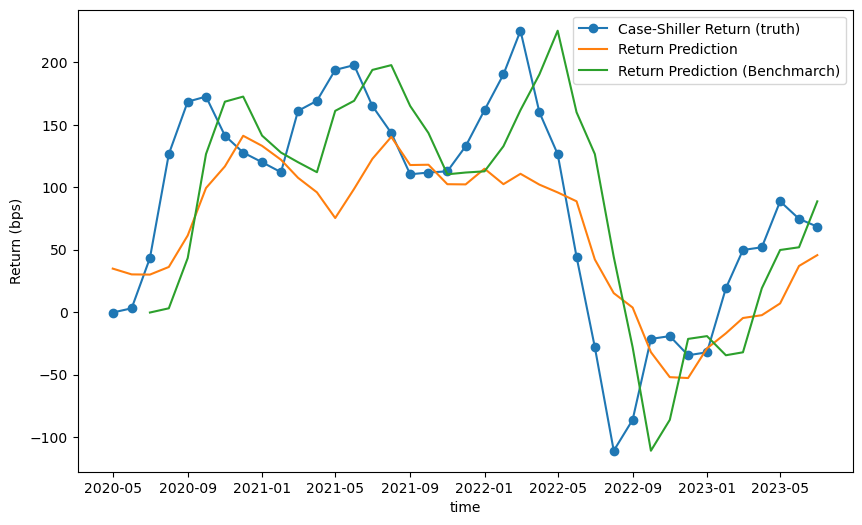

In [328]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_ylabel('Return (bps)') 
ax1.set_xlabel('time')
ax1.plot(final_pred.index.to_timestamp(), final_pred['Case-Shiller Index Ret'], label='Case-Shiller Return (truth)', marker='o')
ax1.plot(final_pred.index.to_timestamp(), final_pred['Prediction_Ret'], label='Return Prediction')
ax1.plot(final_pred.index.shift(2).to_timestamp()[:-2], final_pred['Case-Shiller Index Ret'].iloc[:-2], label='Return Prediction (Benchmarch)')


ax1.tick_params(axis='y')
plt.legend()
plt.show()

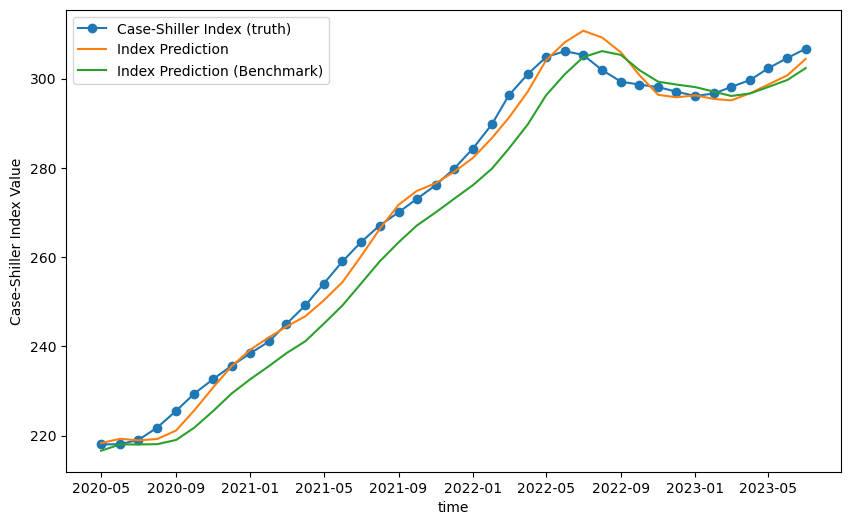

In [317]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'blue'
ax1.set_xlabel('time')
ax1.set_ylabel('Case-Shiller Index Value')
ax1.tick_params(axis='y')

ax1.plot(final_pred.index.to_timestamp(), final_pred['Case-Shiller Index'], label='Case-Shiller Index (truth)', marker='o')
ax1.plot(final_pred.index.to_timestamp(), final_pred['Prediction_Index'], label='Index Prediction')
ax1.plot(final_pred.index.to_timestamp(), final_pred['BM_Prediction_Index'], label='Index Prediction (Benchmark)')

plt.legend()
plt.show()

We see that our prediction is better than benchmark which uses (T-2) month's latest value. Let's compare the RMSE of index value prediction vs a constant benchmark

In [319]:
lgb_rmse = mean_squared_error(final_pred['Prediction_Index'], final_pred['Case-Shiller Index'])
bm_rmse = mean_squared_error(final_pred['BM_Prediction_Index'], final_pred['Case-Shiller Index'])
print(f'RMSE of LGBM model {lgb_rmse:.2f}, RMSE of Benchmark model {bm_rmse:.2f}')

RMSE of LGBM model 8.77, RMSE of Benchmark model 39.86


If needed, use the following code to use the most important features.

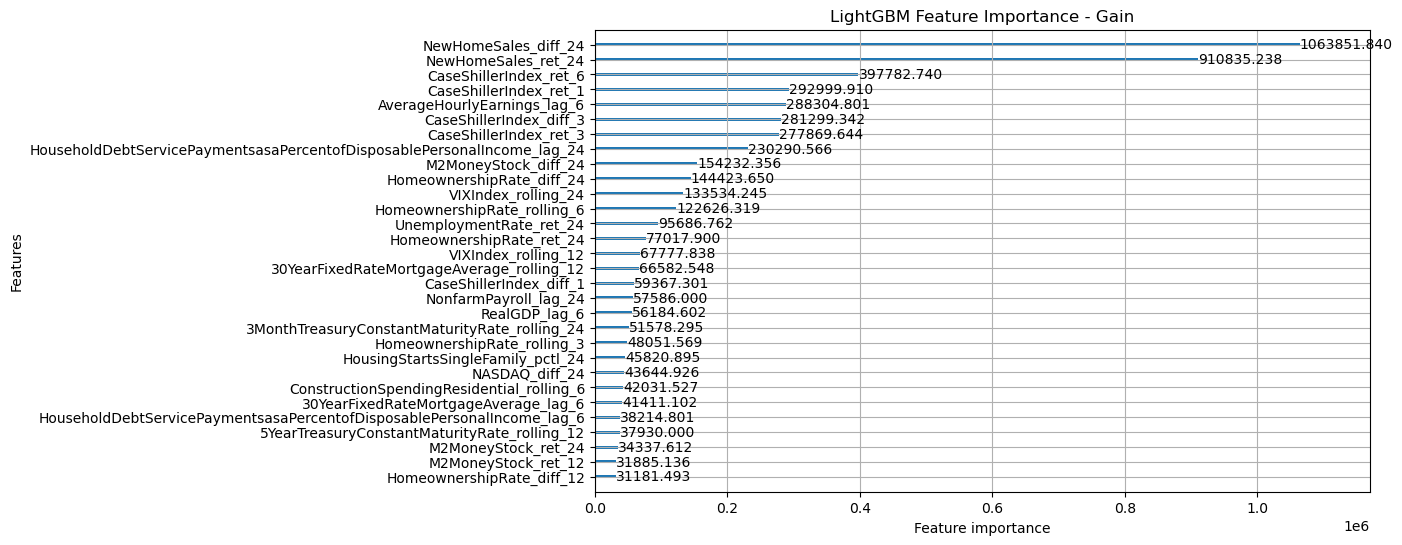

In [290]:
# Plot feature importance by gain
lgb.plot_importance(model, max_num_features=30, importance_type='gain', figsize=(10, 6))
plt.title("LightGBM Feature Importance - Gain")
plt.show()